In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 1. Видалення поганого формату

In [4]:
import cv2
from PIL import Image

In [5]:
data_dir = 'data' 
validationdata_dir = 'validationdata' 


In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = Image.open(image_path)
            img_format = img.format.lower()
            if img_format not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

# 2. Загрузка данних

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1124 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

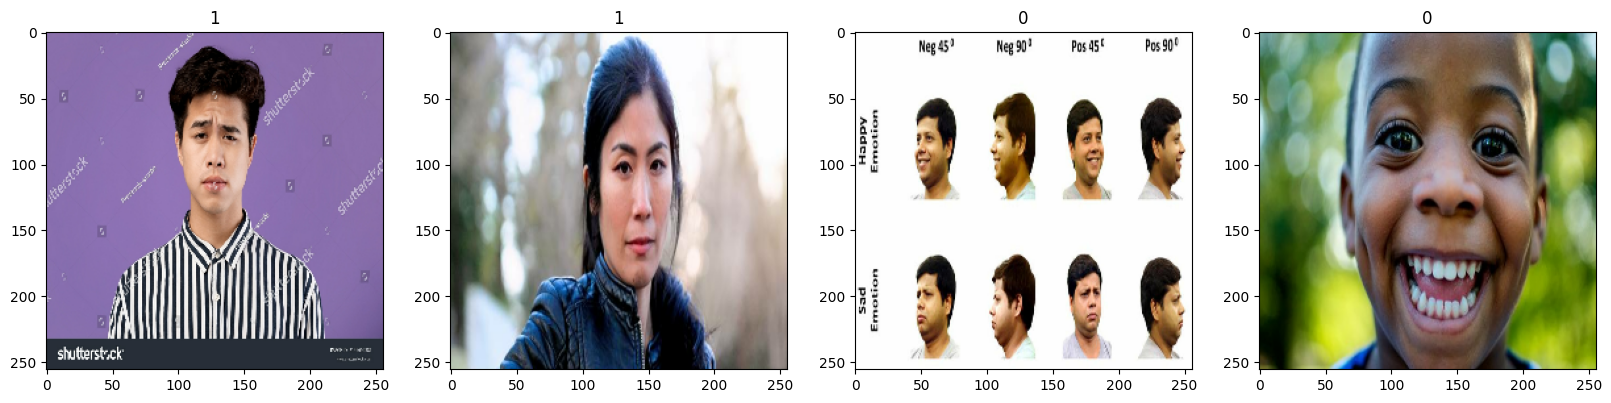

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 3. Підганяємо під розмір 

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
batch = data.as_numpy_iterator().next()

# 4. Спліт

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size

25

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 5. Модель

In [18]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

train_data_dir = 'data'  # Directory containing training data
validation_data_dir = 'validationdata'  # Directory containing validation data

In [24]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [82]:

input_layer = Input(shape=(256, 256, 3))  # Визначення об'єкта Input з відповідними розмірами

x = Conv2D(16, (3,3), 1, activation='relu')(input_layer)
x = MaxPooling2D()(x)
x = Conv2D(32, (3,3), 1, activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(16, (3,3), 1, activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)  

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [83]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 480ms/step - accuracy: 0.4733 - loss: 0.8333 - val_accuracy: 0.6518 - val_loss: 0.6751
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 459ms/step - accuracy: 0.6034 - loss: 0.6710 - val_accuracy: 0.5982 - val_loss: 0.6426
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 575ms/step - accuracy: 0.6633 - loss: 0.5942 - val_accuracy: 0.6518 - val_loss: 0.6098
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 477ms/step - accuracy: 0.7486 - loss: 0.5297 - val_accuracy: 0.7455 - val_loss: 0.5293
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 542ms/step - accuracy: 0.8454 - loss: 0.3992 - val_accuracy: 0.7500 - val_loss: 0.5254
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 481ms/step - accuracy: 0.8897 - loss: 0.3189 - val_accuracy: 0.8080 - val_loss: 0.4342
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 520ms/step - accuracy: 0.9264 - loss: 0.2386 - val_accuracy: 0.8438 - val_loss: 0.4059
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - accuracy: 0.9351 - loss: 0.1728 - val_accu

model.show()

# 7. ТОчність

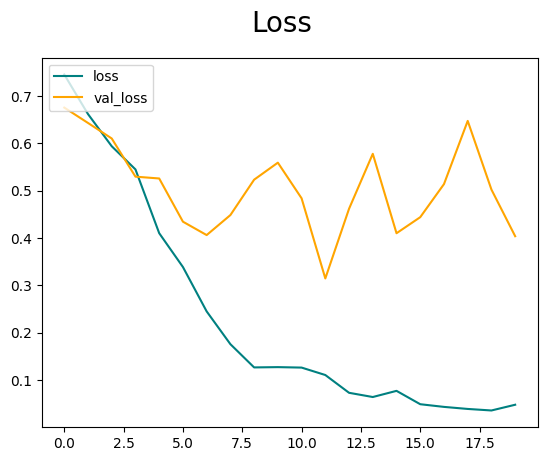

In [84]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

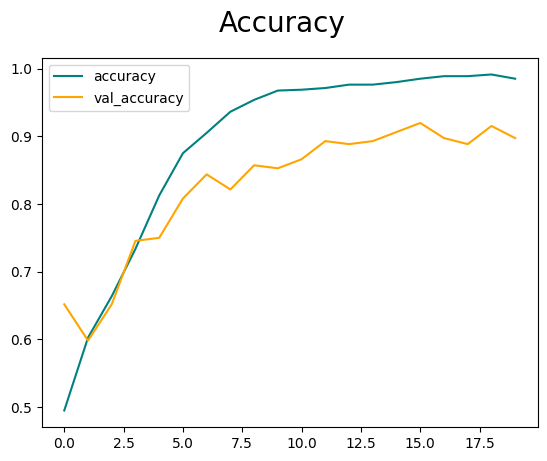

In [85]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8. Оцінка фотографії сумна чи весела

In [86]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [87]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [88]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


In [89]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.88, shape=(), dtype=float32) tf.Tensor(0.8979592, shape=(), dtype=float32) tf.Tensor(0.8854167, shape=(), dtype=float32)


# 9. Тест

In [90]:
import cv2

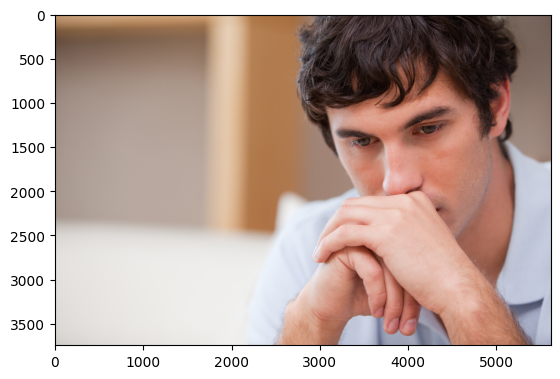

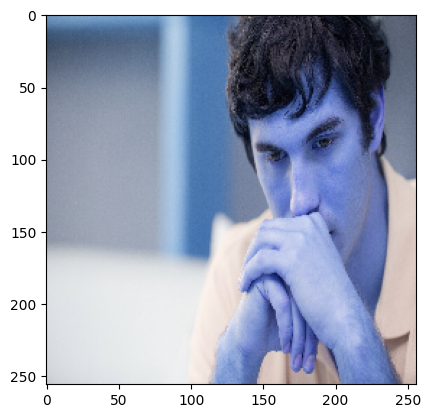

In [91]:
img = cv2.imread('8iAb9k4aT.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

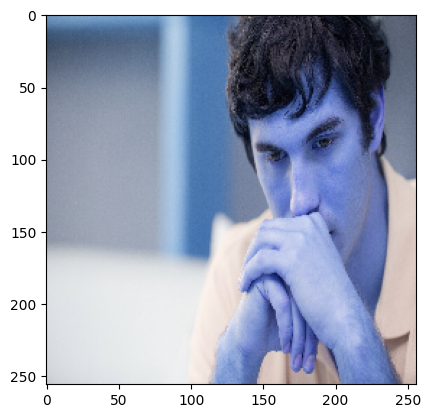

In [92]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [93]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


In [94]:
yhat

array([[0.99994475]], dtype=float32)

In [95]:
if yhat > 0.50: 
    print(f'Sad')
else:
    print(f'Happy')

Sad


# Збереження моделі

In [46]:
from tensorflow.keras.saving import load_model
from tensorflow.keras.models import save_model
os.getcwd()

'C:\\ImageClassification'

In [47]:
model.save('imageclassifier.keras')


In [48]:
new_model = load_model('imageclassifier.keras')

In [49]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


array([[0.2097413]], dtype=float32)